In [5]:
from scipy.optimize import minimize
import warnings
import pandas as pd
import numpy as np

def get_chara_func_heston(x, sigma, k, rho, s0, r, t, theta, v0, q):
    lambd = np.sqrt(np.power(sigma, 2)*(np.power(x, 2)+1j*x) + np.power(k - 1j*rho*sigma*x, 2))
    omega = np.exp(1j*x*np.log(s0)+1j*x*(r-q)*t+(k*theta*t*(k - 1j*rho*sigma*x)/np.power(sigma, 2)))/\
        ((np.cosh(lambd*t/2) + ((k - 1j*rho*sigma*x)/lambd)*np.sinh(lambd*t/2))**((2*k*theta)/np.power(sigma, 2)))
    result = omega * np.exp(-((np.power(x, 2) + 1j*x)*v0)/(lambd*(1/np.tanh(lambd*t/2)) + (k - 1j*rho*sigma*x)))
    return result

def get_heston_price(alpha, N, delta_v, sigma, k, rho, t, theta, v0, K=None):
    r = 0.035
    s0 = 500
    q = 0.0135
    deltas = np.zeros(N)
    deltas[0] = 1
    delta_k = (2*np.pi)/(N*delta_v)
    v_list = np.arange(N) * delta_v
    numerator = np.array( [((2-deltas[i])*delta_v)*np.exp(-r*t) for i in range(N)] )
    denominator = np.array( [2 * (alpha + 1j*i) * (alpha + 1j*i + 1) for i in v_list] )
    if K == None:
        beta = np.log(s0) - delta_k*N*0.5
    else:
        beta = np.log(K) - delta_k*N*0.5
    x_exp = np.array( [np.exp(-1j*(beta)*i) for i in v_list] )
    xs = (numerator/denominator)*x_exp* np.array([get_chara_func_heston(i - 1j*(alpha+1),sigma, k,rho,s0,r,t,theta,v0, q) for i in v_list])
    ys = np.fft.fft(xs)
    prices = np.array( [(1/np.pi) * np.exp(-alpha*(beta +(i-1)*delta_k)) * np.real(ys[i-1]) for i in range(1,N+1)])
    return prices[int(N/2)]


In [11]:
import numpy as np
from scipy.optimize import minimize
import warnings
import pandas as pd

warnings.filterwarnings("ignore")

# Provided functions: get_chara_func_heston, get_heston_price

# Guessed Heston parameters
sigma = 0.1  # Volatility of volatility
k = 1.5  # Mean reversion speed
rho = -0.6  # Correlation
theta = 0.05  # Long-term variance
v0 = 0.05  # Initial variance

# Option and market parameters
s0 = 500  # Last closing price of SPY
r = 0.035  # Risk-free rate
q = 0.0135  # Dividend yield
t = 1  # Time to expiry
K = 540  # Strike price

# FFT parameters
alpha = 1.2  # Damping factor
N = 2**11  # Number of FFT points
delta_v = 0.25  # FFT frequency domain grid spacing

# Calculate option price using FFT
option_price = get_heston_price(alpha, N, delta_v, sigma, k, rho, t, theta, v0, K)
print(f'Option price using FFT with guessed parameters: {option_price:.4f}')


Option price using FFT with guessed parameters: 31.6575


In [16]:
#Problem 2

In [12]:
T = 1.0  # Time to maturity in years
N = 10_000  # Number of simulated paths
steps_per_year = 252  # Trading days in a year
Delta_T = 1 / steps_per_year  # Time step in years
total_steps = int(T * steps_per_year)  # Total number of time steps

print(f"Time Spacing (Delta_T): {Delta_T}")
print(f"Total Steps: {total_steps}")
print(f"Number of Simulated Paths (N): {N}")


Time Spacing (Delta_T): 0.003968253968253968
Total Steps: 252
Number of Simulated Paths (N): 10000


In [13]:
import numpy as np

# Define the Heston model parameters in a dictionary for better organization and readability.
heston_params = {
    'S0': 500,     # Spot price of the underlying asset.
    'V0': 0.04,    # Initial variance of the underlying asset.
    'K': 540,      # Strike price of the option.
    'T': 1,        # Time to maturity (in years).
    'r': 0.035,    # Risk-free interest rate (annual).
    'q': 0.0135,   # Dividend yield (annual).
    'kappa': 3.52, # Speed of mean reversion for the variance.
    'theta': 0.052,# Long-term variance.
    'sigma': 1.18, # Volatility of the variance.
    'rho': -0.77,  # Correlation between the two Brownian motions.
}

def simulate_heston_paths(heston_params, num_paths, num_steps):
    """
    Simulates asset price paths under the Heston model.
    """
    dt = heston_params['T'] / num_steps
    S = np.zeros((num_steps + 1, num_paths))
    v = np.zeros((num_steps + 1, num_paths))
    S[0] = heston_params['S0']
    v[0] = heston_params['V0']
    
    for t in range(1, num_steps + 1):
        dW1 = np.random.normal(scale=np.sqrt(dt), size=num_paths)
        dW2 = np.random.normal(scale=np.sqrt(dt), size=num_paths)
        dW2 = heston_params['rho'] * dW1 + np.sqrt(1 - heston_params['rho']**2) * dW2  # Correlated Brownian motion.
        
        v[t] = np.maximum(v[t-1] + heston_params['kappa'] * (heston_params['theta'] - v[t-1]) * dt + heston_params['sigma'] * np.sqrt(v[t-1]) * dW2, 0)
        S[t] = S[t-1] * np.exp((heston_params['r'] - heston_params['q'] - 0.5 * v[t-1]) * dt + np.sqrt(v[t-1]) * dW1)
    
    return S

def price_european_call_via_monte_carlo(heston_params, num_paths=100000, num_steps=252):
    """
    Prices a European call option using Monte Carlo simulation under the Heston model.
    """
    S = simulate_heston_paths(heston_params, num_paths, num_steps)
    payoff = np.maximum(S[-1] - heston_params['K'], 0)
    return np.mean(payoff) * np.exp(-heston_params['r'] * heston_params['T'])

# Calculate the price of the European call option using the Monte Carlo simulation.
mc_call_price = price_european_call_via_monte_carlo(heston_params)
print(f"European Call Price (Monte Carlo): {mc_call_price:.4f}")


European Call Price (Monte Carlo): 24.8287


In [14]:
# This part assumes the existence of a get_heston_price function that implements the FFT method.
# For demonstration, let's assume its signature and use it directly.

alpha = 1.5  # Damping factor for better FFT convergence
N = 2**12   # Number of points in FFT
delta_v = 0.25  # Frequency domain grid spacing

# Assuming the existence of get_heston_price and characteristic function
fft_price = get_heston_price(alpha, N, delta_v, heston_params['sigma'], heston_params['kappa'], heston_params['rho'], heston_params['T'], heston_params['theta'], heston_params['V0'], K=heston_params['K'])
print(f"European Call Price (FFT): {fft_price:.4f}")


European Call Price (FFT): 20.8305


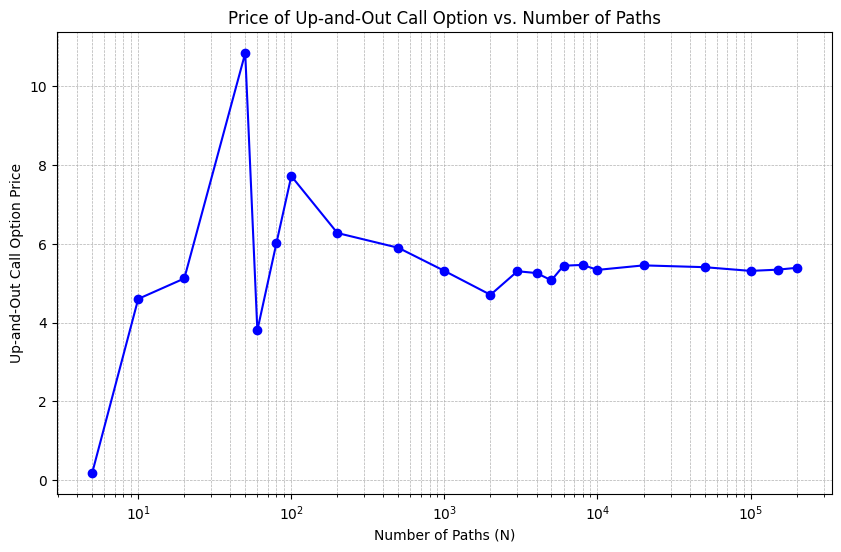

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Updated Heston model parameters
heston_params = {
    'S0': 500,     # Spot price of the underlying asset.
    'V0': 0.04,    # Initial variance of the underlying asset.
    'K1': 540,     # Strike price of the option.
    'K2': 600,     # Barrier level for the up-and-out call.
    'T': 1,        # Time to maturity (in years).
    'r': 0.035,    # Risk-free interest rate (annual).
    'q': 0.0135,   # Dividend yield (annual).
    'kappa': 3.52, # Speed of mean reversion for the variance.
    'theta': 0.052,# Long-term variance.
    'sigma': 1.18, # Volatility of the variance.
    'rho': -0.77,  # Correlation between the two Brownian motions.
}

def simulate_heston_paths(heston_params, num_paths, num_steps):
    """
    Simulates asset price paths under the Heston model.
    """
    dt = heston_params['T'] / num_steps
    S = np.zeros((num_steps + 1, num_paths))
    v = np.zeros((num_steps + 1, num_paths))
    S[0] = heston_params['S0']
    v[0] = heston_params['V0']
    
    for t in range(1, num_steps + 1):
        dW1 = np.random.normal(scale=np.sqrt(dt), size=num_paths)
        dW2 = np.random.normal(scale=np.sqrt(dt), size=num_paths)
        dW2 = heston_params['rho'] * dW1 + np.sqrt(1 - heston_params['rho']**2) * dW2  # Correlated Brownian motion.
        
        v[t] = np.maximum(v[t-1] + heston_params['kappa'] * (heston_params['theta'] - v[t-1]) * dt + heston_params['sigma'] * np.sqrt(v[t-1]) * dW2, 0)
        S[t] = S[t-1] * np.exp((heston_params['r'] - heston_params['q'] - 0.5 * v[t-1]) * dt + np.sqrt(v[t-1]) * dW1)
    
    return S

def price_up_and_out_call(heston_params, num_paths=10000, num_steps=252):
    """
    Prices an up-and-out European call option using Monte Carlo simulation under the Heston model.
    """
    S = simulate_heston_paths(heston_params, num_paths, num_steps)
    payoff = np.where(np.max(S, axis=0) < heston_params['K2'], np.maximum(S[-1] - heston_params['K1'], 0), 0)
    return np.mean(payoff) * np.exp(-heston_params['r'] * heston_params['T'])

# Adjusted set of values for N
N_values = [5, 10, 20, 50,60,80, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 8000, 10000,20000,50000,100000,150000,200000]

# Prices for each N
prices = [price_up_and_out_call(heston_params, num_paths=N) for N in N_values]

# Plotting the updated values and prices
plt.figure(figsize=(10, 6))
plt.plot(N_values, prices, marker='o', linestyle='-', color='blue')
plt.xscale('log')  # Keeping the log scale for better visualization across a wide range of N
plt.xlabel('Number of Paths (N)')
plt.ylabel('Up-and-Out Call Option Price')
plt.title('Price of Up-and-Out Call Option vs. Number of Paths')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
